In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from vtk import vtkXMLUnstructuredGridReader
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
import pygmt

os.chdir("../postprocessing_scripts/")
import MORVEL
import parallel_curves
os.chdir("../main_figures/")

In [2]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, theta, phi

def spherical_to_global_cartesian(r, theta, phi):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

In [3]:
data_dir_path = "../data/" # Load in the regional dataset from Donna
AUS_eastprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith75.xyd", comments='>')
AUS_MB = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith150.xyd", comments='>')
AUS_westprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith100.xyd", comments='>')
AUS_TVZ = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith50.xyd", comments='>')

PAC_eastprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith75.xyd", comments='>')
PAC_MB = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith150.xyd", comments='>')
PAC_westprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith100.xyd", comments='>')
HIK_plateau = np.loadtxt(fname=data_dir_path + "Hikurangi_Plateau_wgs84.csv", delimiter=',', skiprows=1)
HIK_plateau = np.delete(HIK_plateau, [83, -1], axis=0)
for i in range(len(HIK_plateau)):
    if HIK_plateau[:, 0][i] < 0:
        HIK_plateau[:, 0][i] += 360

profile_directory = "../slab2_worldbuilder_generation/profiles_for_worldbuilder/geographic/"
trench_lon = np.empty(0)
trench_lat = np.empty(0)
for file in np.sort(os.listdir(profile_directory)):
    profile_file = np.loadtxt(fname=profile_directory + file)
    trench_ind = np.where(profile_file[:, 0] == np.max(profile_file[:, 0]))
    trench_lon = np.concatenate( (trench_lon, np.array([profile_file[:, 0][trench_ind][0]])))
    trench_lat = np.concatenate( (trench_lat, np.array([profile_file[:, 1][trench_ind][0]])))

trench = np.loadtxt(fname=data_dir_path + "trench_contour.csv", delimiter=',')[0:270]

In [4]:
sol_dir_path = "../ASPECT_models/5e20_10kmweak_dry/solution/"

solutions = np.sort(os.listdir( sol_dir_path ))
t_step = 0

pos_solution = np.empty(0)
stress_total = np.empty(0)
stress_second_invariant = np.empty(0)

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        
        file_path = os.path.join(sol_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        stress = vtk_to_numpy(data.GetPointData().GetArray('stress'))
        sigma_ii = vtk_to_numpy(data.GetPointData().GetArray('stress_second_invariant'))
        
        if len(pos_solution) == 0:
            pos_solution = x
            stress_total = stress
        else:
            pos_solution = np.concatenate( (pos_solution, x) )
            stress_total = np.concatenate( (stress_total, stress) )
            
        stress_second_invariant = np.concatenate( (stress_second_invariant, sigma_ii) )

In [5]:
ASPECT_r, ASPECT_theta, ASPECT_phi = cartesian_to_spherical(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2])
lat_bounds = np.array([-43, -32])
lon_bounds = np.array([170, 183.5])
dr = 100
depth = 5e3
radius_val = 6371e3 - depth
radius_bounds = np.array([radius_val - dr, radius_val + dr])
Hik_indices = np.where( (ASPECT_theta >= np.min(lat_bounds)) & (ASPECT_theta <= np.max(lat_bounds)) & \
                        (ASPECT_phi >= np.min(lon_bounds)) & (ASPECT_phi <= np.max(lon_bounds)) & \
                        (ASPECT_r >= np.min(radius_bounds)) & (ASPECT_r <= np.max(radius_bounds)) )
local_r = ASPECT_r[Hik_indices]
local_theta = ASPECT_theta[Hik_indices]
local_phi = ASPECT_phi[Hik_indices]
local_stress = stress_total[Hik_indices]
local_stress_second_invariant = stress_second_invariant[Hik_indices]

# Try rotating the stress tensor to the spherical system

In [6]:
from numpy import linalg as LA
radial_stresses = np.empty(0)
theta_stresses = np.empty(0)
phi_stresses = np.empty(0)

principal_stresses = np.empty(0)
principal_directions = np.empty(0)

in_plane_principal_stresses = np.empty(0)
in_plane_principal_directions = np.empty(0)

for i in range(len(local_stress)):
    stress_tensor = np.array([[local_stress[i][0], local_stress[i][1], local_stress[i][2]],
                              [local_stress[i][3], local_stress[i][4], local_stress[i][5]],
                              [local_stress[i][6], local_stress[i][7], local_stress[i][8]]])

    rotation_matrix = np.array([[np.sin(90 - local_theta[i]) * np.cos(local_phi[i]), \
                                 np.sin(90 - local_theta[i]) * np.sin(local_phi[i]), \
                                 np.cos(90 - local_theta[i])], \
                               
                                [np.cos(90 - local_theta[i]) * np.cos(local_phi[i]), \
                                 np.cos(90 - local_theta[i]) * np.sin(local_phi[i]), \
                                 -np.sin(90 - local_theta[i])], \
                                
                                [-np.sin(local_phi[i]), \
                                 np.cos(local_phi[i]), \
                                 0]])
    
    global_spherical_stress_tensor = np.matmul(np.matmul(rotation_matrix, stress_tensor), rotation_matrix.T)

    NSEW_rotation_matrix = np.array([[1, 0, 0], 
                                     [0, -1, 0], 
                                     [0, 0, 1]])

    spherical_stress_tensor = np.matmul(np.matmul(NSEW_rotation_matrix, global_spherical_stress_tensor), NSEW_rotation_matrix.T)

    radial_stresses = np.append(radial_stresses, spherical_stress_tensor[0][0])
    theta_stresses = np.append(theta_stresses, spherical_stress_tensor[1][1])
    phi_stresses = np.append(phi_stresses, spherical_stress_tensor[2][2])

    in_plane_tensor = np.array([[spherical_stress_tensor[1][1], spherical_stress_tensor[1][2]],
                                [spherical_stress_tensor[2][1], spherical_stress_tensor[2][2]]])

    in_plane_stress, in_plane_direction = LA.eig(in_plane_tensor)
    if len(in_plane_principal_stresses) == 0:
        in_plane_principal_stresses = in_plane_stress
        in_plane_principal_directions = in_plane_direction
    else:
        in_plane_principal_stresses = np.vstack( (in_plane_principal_stresses, in_plane_stress) )
        in_plane_principal_directions = np.vstack( (in_plane_principal_directions, in_plane_direction) )        

In [7]:
max_stress = np.zeros(len(in_plane_principal_stresses))
max_directions = np.empty(0)

min_stress = np.zeros(len(in_plane_principal_stresses))
min_directions = np.empty(0)
for i in range(len(max_stress)):
    min_index = in_plane_principal_stresses[i].argmin()
    max_index = in_plane_principal_stresses[i].argmax()
    max_stress[i] = in_plane_principal_stresses[i][max_index]
    min_stress[i] = in_plane_principal_stresses[i][min_index]

    max_direction_single = in_plane_principal_directions[i*2 + max_index]
    min_direction_single = in_plane_principal_directions[i*2 + min_index]
    if len(min_directions) == 0:
        max_directions = max_direction_single
        min_directions = min_direction_single
    else:
        max_directions = np.vstack( (max_directions, max_direction_single) )
        min_directions = np.vstack( (min_directions, min_direction_single) )

In [8]:
vector_points = 25
phi_for_quiver = np.linspace(np.min(local_phi), np.max(local_phi), vector_points)
theta_for_quiver = np.linspace(np.min(local_theta), np.max(local_theta), vector_points)
PHI, THETA = np.meshgrid(phi_for_quiver, theta_for_quiver)
stress_KDTREE = KDTree(np.c_[local_theta, local_phi])
MAX_STRESS_VECTORS = np.empty(0)
MIN_STRESS_VECTORS = np.empty(0)
CROSS_STRESS_VECTORS_MIN = np.empty(0)
CROSS_STRESS_VECTORS_MAX = np.empty(0)
max_max_stress = np.max(max_stress)
max_min_stress = np.max(min_stress)
ave_max_stress = np.average(max_stress) * 5
ave_min_stress = np.average(min_stress) * 5
vector_length = 1
theta_ind = 0
phi_ind = 1

for i in range(len(PHI.flatten())):
    dd, ii = stress_KDTREE.query([THETA.flatten()[i], PHI.flatten()[i]])

    cross_azimuth = np.rad2deg(np.arctan(abs(max_directions[ii][phi_ind] / max_directions[ii][theta_ind])))
    if np.sign(max_directions[ii][theta_ind]) >= 0:
        if np.sign(max_directions[ii][phi_ind]) >= 0:
            cross_azimuth = cross_azimuth
            cross_azimuth += 0
        elif np.sign(max_directions[ii][phi_ind]) < 0:
            cross_azimuth = -cross_azimuth
            cross_azimuth += 360
    elif np.sign(max_directions[ii][theta_ind]) < 0:
        if np.sign(max_directions[ii][phi_ind]) < 0:
            cross_azimuth = cross_azimuth
            cross_azimuth += 180
        elif np.sign(max_directions[ii][phi_ind]) >= 0:
            cross_azimuth = -cross_azimuth
            cross_azimuth += 180    

    cross_vector_max = np.array([PHI.flatten()[i], \
                                 THETA.flatten()[i], \
                                 abs(min_stress[ii] / ave_max_stress)*0, \
                                 abs(max_stress[ii] / ave_max_stress), \
                                 cross_azimuth])
    
    cross_vector_min = np.array([PHI.flatten()[i], \
                                 THETA.flatten()[i], \
                                 abs(min_stress[ii] / ave_max_stress), \
                                 abs(max_stress[ii] / ave_max_stress)*0, \
                                 cross_azimuth])
    
    if len(CROSS_STRESS_VECTORS_MAX) == 0:
        CROSS_STRESS_VECTORS_MAX = cross_vector_max
        CROSS_STRESS_VECTORS_MIN = cross_vector_min
    else:
        CROSS_STRESS_VECTORS_MAX = np.vstack( (CROSS_STRESS_VECTORS_MAX, cross_vector_max) )
        CROSS_STRESS_VECTORS_MIN = np.vstack( (CROSS_STRESS_VECTORS_MIN, cross_vector_min) )

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
gmtset [ERROR]: Pen name None not recognized!
gmtset [WARNING]: Representation of pen width (None) not recognized. Using 

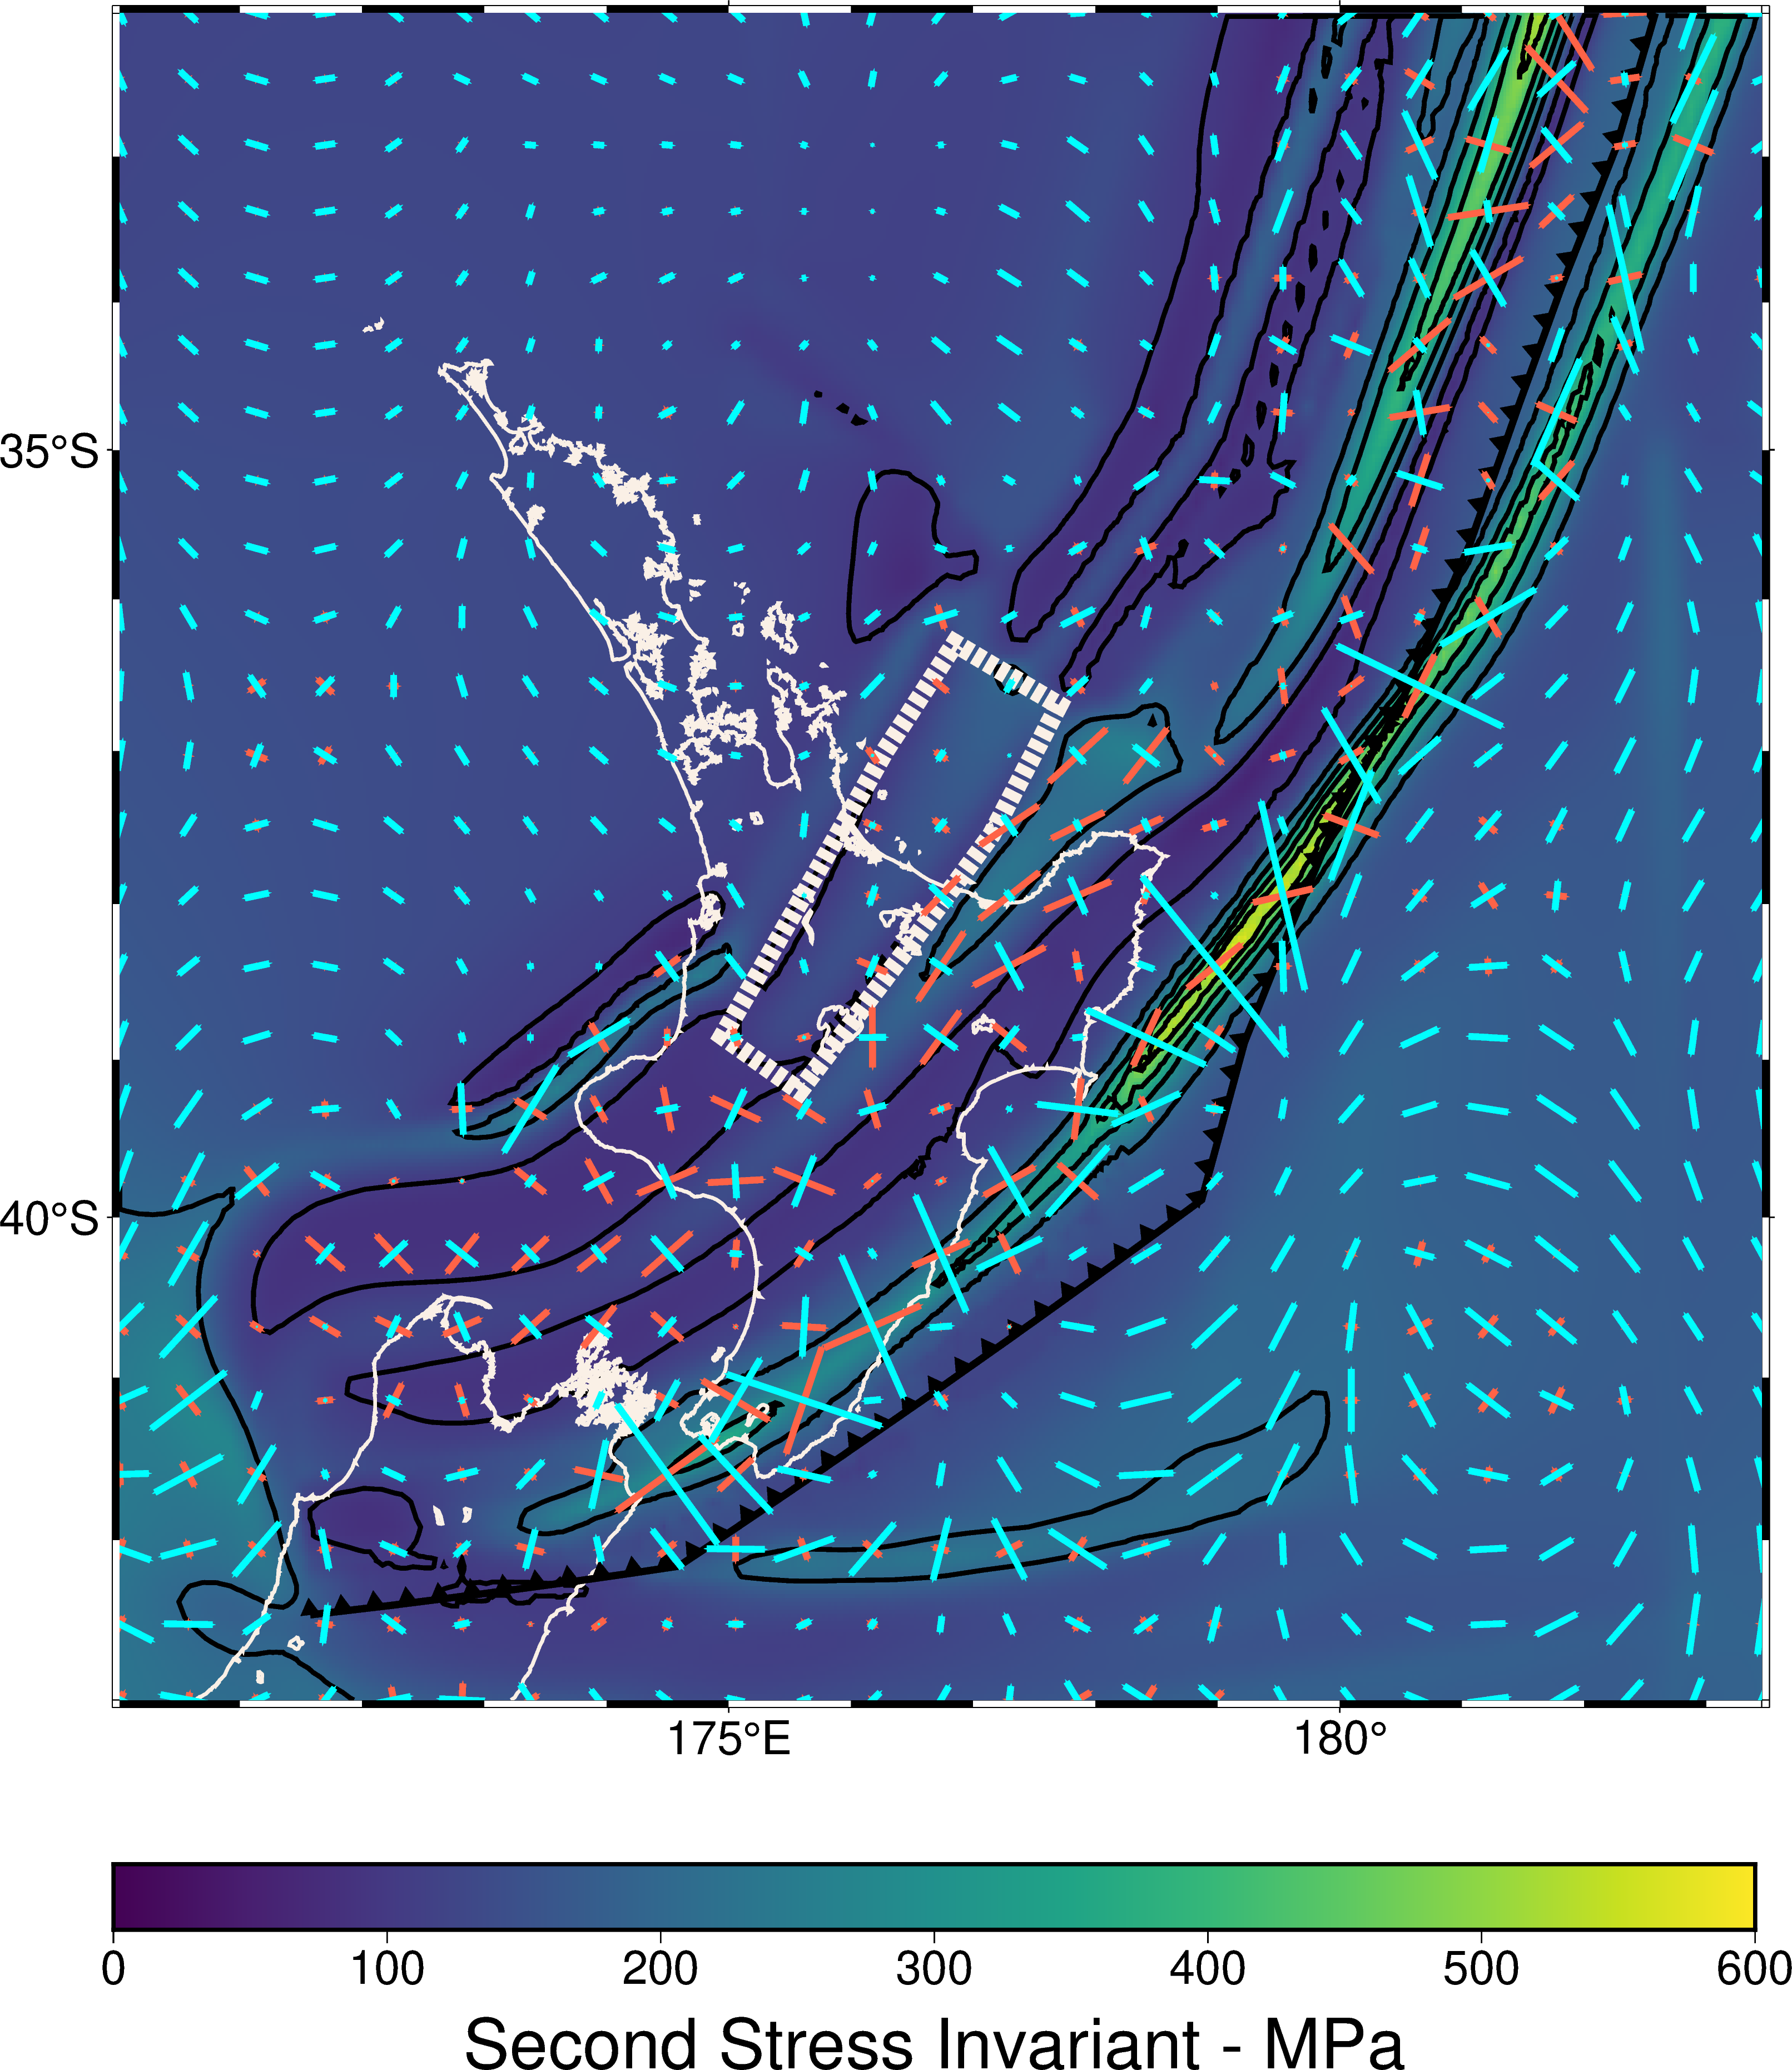

In [17]:
import pandas as pd
plot_region = [np.min(local_phi), np.max(local_phi), np.min(local_theta), np.max(local_theta)]

df_original = pd.DataFrame({'LON':local_phi,
                   'LAT':local_theta,
                   'STRESS':local_stress_second_invariant / 1e6})

df = pygmt.blockmean(data=df_original, region=plot_region, spacing='0.05+e')
stress_grid = pygmt.surface(data=df, spacing=0.025, region=plot_region, tension=0.9)
fig = pygmt.Figure()
pygmt.config(FONT_LABEL='30p', MAP_LABEL_OFFSET='0.5', MAP_TICK_PEN_PRIMARY=None, FONT_ANNOT_PRIMARY='20p')


pygmt.makecpt(cmap="viridis", series=[0, 600, 50], continuous=True, reverse=False)


fig.basemap(region=plot_region, projection="M25c", frame=["af"])
fig.grdimage(grid=stress_grid, nan_transparent=True)
fig.colorbar(position="JBC+o-0.1c/2.5c+w25c/1c+h", frame=["100", "x+lSecond Stress Invariant - MPa"])

fig.contour(data=df, pen='2p,black', levels=100, annotation="100+f20p,white", label_placement="d5000")

fig.coast(
    shorelines="1.5p,linen",
    transparency=0
)

fig.plot(x=AUS_TVZ[:, 0], y=AUS_TVZ[:, 1], pen='8p,linen,4_2:2p')
fig.plot(x=trench_lon, y=trench_lat, pen="3p", style="f0.5c/0.3c+l+to0.3c+p", fill='black')

min_color = 'brown1'
max_color = 'turquoise1'
fig.velo(data=CROSS_STRESS_VECTORS_MIN, spec="x1.25", vector="0.05c+p0.1c,tomato+b")
fig.velo(data=CROSS_STRESS_VECTORS_MAX, spec="x1.25", vector="0.05c+p0.1c,cyan+e")

fig.show()
fig.savefig('stress_state.png')